In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.utils import shuffle


Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [63]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC2_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')


# @param Definition des table et colonnes --> Dépendent de la DB
DB             = "Delitraiteur_qualif_bacpac.bacpac_20220706"
TABLE_CONSO    = "Consommateur"
TABLE_ENTETE   = "Recette_entete_ticket"
TEMPS_ENTETE   = TABLE_ENTETE             + ".TEMPS.KEY"
NUMERO_ENTETE  = TABLE_ENTETE             + ".Reference_ticket"
TABLE_DETAIL   = "Fidelite_detail_ticket"
TEMPS_DETAIL   = TABLE_DETAIL             + ".TEMPS_KEY_Date_reel_transaction"
NUMERO_DETAIL  = TABLE_DETAIL             + ".Reference_ticket"
FIDELITE_DETAIL = TABLE_DETAIL + ".Carte_fidelite"
TABLE_ARTICLE  = "Article_meti_HIST"
TABLE_UNIVERS  = "Univers"

Univers_Depth  = 3            # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_client     = -1           # Nombre de clients à sélectionner. MAX = 148188. -1 --> ALL
client_tresh   = 15           # Nombre d'article que le client doit avoir acheter pour être mis dans un segment
univers_tresh  = 15           # Nombre d'article acheté de l'univers pour qu'il soit pris en compte

# @param Sur la normalization des données
Standard_Norm  = False        # Défini si on utilise la Normalization Standard
Standard_Tresh = 1            # Seuil d'acceptabilité des cluster en normalization standard
MinMax_Norm    = True         # Défini si on utilise la Normalization Minmax
MinMax_Tesh    = .3           # Seuil d'acceptabilité des cluster par défaut

# @param Sur le modèle KMean
K              = 14            # Nombre de segment. K = 21 -> 10% client d'exclu ; K = 15 -> 15% client exclu ; K = 9 -> 20% exclu 
n_init         = 100           # Nombre de run du KMean pour trouver le meilleur min

# @param Sur l'analyse des données
do_Analysis    = True        # Est-ce qu'on fait l'analyse des Elbow ou pas ?
Kmin           = 5            # Nombre de cluster au début de l'analyse
Kmax           = 30           # Nombre de cluster à la fin de l'analyse


# @param Hierchaical/Agglomerative Clustering
max_fitted = 10000
method     = 'ward'            # types de méthode: ward complete average single
 
# @param PCA
threeD         = False         # Afficher le graphe 3D dans les projection PCA
nbr_dim_keep   = 10            # Nombre de dimension gardée lors du KMeans effectué après un PCA    
K_PCA          = K             # K pour KMeans après le PCA

In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_CONSO+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_CONSO+"]", conn)
print(df)

conn.close()

   Consommateur.KEY
0                -1
1             35427
2             50938
3             20414
4             20973
5             25696
6            140306
7             30549
8             32394
9             39976


## LOAD & PREPROCESSING DATA

In [8]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + TABLE_ENTETE + '''.KEY] AS ''' + TABLE_CONSO + '''
FROM  ['''      + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL + ''']
ON ['''    + TABLE_DETAIL  + '''.''' + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE + '''] 
ON   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
WHERE [''' + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS  + '''.KEY] != -1 
AND ['''   + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''   + TABLE_ENTETE  + '''.KEY] < ''' + str(5000000) + ''' 
AND ['''   + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS + '''.KEY] != 388'''
#AND    [''' + TEMPS_DETAIL  +'''] = [''' + TEMPS_ENTETE  + '''] 

print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 5min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)

client_tresh = 5
K = 14

SELECT [Article_meti_HIST.Univers.KEY] AS Univers
,[Recette_entete_ticket.Consommateur.KEY] AS Consommateur
FROM  [Delitraiteur_qualif_bacpac.bacpac_20220706].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Delitraiteur_qualif_bacpac.bacpac_20220706].[DWH].[Fact_Fidelite_detail_ticket]
ON [Fidelite_detail_ticket.Article_meti_HIST.KEY] = [Article_meti_HIST.KEY] 
INNER JOIN [Delitraiteur_qualif_bacpac.bacpac_20220706].[DWH].[Fact_Recette_entete_ticket_fidelite] 
ON   [Fidelite_detail_ticket.Reference_ticket] = [Recette_entete_ticket.Reference_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Article_meti_HIST.Univers.KEY] != 388
Time Taken to load DB: ~1secondes
47401


In [12]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + TABLE_ENTETE + '''.''' + TABLE_CONSO + '''.KEY] AS ''' + TABLE_CONSO + '''
FROM  ['''      + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE + '''_fidelite] 
ON   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
ON ['''    + TABLE_DETAIL  + '''.'''    + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
WHERE [''' + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS + '''.KEY] != 388
AND [''' + TABLE_ENTETE + '''.''' + TABLE_CONSO + '''.KEY] != -1'''
if nbr_client != -1:
    sql_command +=  ''' AND [''' + TABLE_ENTETE  +'''.'''     + TABLE_CONSO   + '''.KEY] < '''  + str(nbr_client)

print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 3min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)

SELECT [Article_meti_HIST.Univers.KEY] AS Univers
,[Recette_entete_ticket.Consommateur.KEY] AS Consommateur
FROM  [Delitraiteur_qualif_bacpac.bacpac_20220706].[DWH].[Fact_Fidelite_detail_ticket]
INNER JOIN [Delitraiteur_qualif_bacpac.bacpac_20220706].[DWH].[Fact_Recette_entete_ticket_fidelite] 
ON   [Fidelite_detail_ticket.Reference_ticket] = [Recette_entete_ticket.Reference_ticket]
INNER JOIN [Delitraiteur_qualif_bacpac.bacpac_20220706].[DWH].[Dim_Article_meti_HIST]
ON [Fidelite_detail_ticket.Article_meti_HIST.KEY] = [Article_meti_HIST.KEY] 
WHERE [Article_meti_HIST.Univers.KEY] != 388
AND [Recette_entete_ticket.Consommateur.KEY] != -1
Time Taken to load DB: ~0secondes
41973


In [47]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + FIDELITE_DETAIL + '''] AS ''' + TABLE_CONSO + '''
FROM  ['''      + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
ON ['''    + TABLE_DETAIL  + '''.'''    + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
WHERE [''' + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS + '''.KEY] != 388
AND NOT [''' + FIDELITE_DETAIL + '''] IS NULL'''

print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 3min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)

SELECT [Article_meti_HIST.Univers.KEY] AS Univers
,[Fidelite_detail_ticket.Carte_fidelite] AS Consommateur
FROM  [Delitraiteur_qualif_bacpac.bacpac_20220706].[DWH].[Fact_Fidelite_detail_ticket]
INNER JOIN [Delitraiteur_qualif_bacpac.bacpac_20220706].[DWH].[Dim_Article_meti_HIST]
ON [Fidelite_detail_ticket.Article_meti_HIST.KEY] = [Article_meti_HIST.KEY] 
WHERE [Article_meti_HIST.Univers.KEY] != 388
AND NOT [Fidelite_detail_ticket.Carte_fidelite] IS NULL
Time Taken to load DB: ~0secondes
51563


In [48]:
start = time()

sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
    [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''
print(sql_command)

conn = engine.connect()
df_my_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 0s
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
print(df_my_univers)

SELECT [Univers.KEY],
    [Univers.Libelle_univers1_FR], 
    [Univers.Libelle_univers2_FR], 
    [Univers.Libelle_univers3_FR], 
    [Univers.Libelle_univers4_FR]
    FROM [Delitraiteur_qualif_bacpac.bacpac_20220706].[DWH].[Dim_Univers]
Time Taken to load DB: ~0secondes
     Univers.KEY Univers.Libelle_univers1_FR Univers.Libelle_univers2_FR  \
0             -1                           ?                           ?   
1              1               PRET A MANGER      SERVICE TRAITEUR FROID   
2              2               PRET A MANGER                MEUBLE CHAUD   
3              3               PRET A MANGER                MEUBLE CHAUD   
4              4               PRET A MANGER                MEUBLE CHAUD   
..           ...                         ...                         ...   
492          969     E-COMMERCE & ANTi-GASPI                  LIVRAISONS   
493          970             PRET A CUISINER             SAUCES FRAICHES   
494          971             PRET A CUISINER

In [49]:
univers_correspondance = {}
deleted = set()
for item in df_my_univers.values:
    if item[0] in deleted:
        continue
    for cor in df_my_univers.values: 
        if item[0] != cor[0]:
            if (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
                deleted.add(cor[0])
print(univers_correspondance)

{428: 1, 429: 1, 3: 2, 4: 2, 5: 2, 8: 7, 28: 27, 32: 31, 39: 38, 40: 38, 42: 41, 43: 41, 44: 41, 46: 45, 47: 45, 48: 45, 49: 45, 50: 45, 462: 51, 475: 51, 62: 61, 63: 61, 71: 70, 72: 70, 73: 70, 89: 88, 90: 88, 91: 88, 93: 92, 456: 125, 463: 125, 464: 125, 465: 125, 466: 125, 467: 125, 468: 125, 130: 129, 137: 136, 139: 138, 140: 138, 181: 180, 182: 180, 183: 180, 184: 180, 185: 180, 186: 180, 187: 180, 469: 213, 476: 213, 216: 215, 218: 217, 225: 224, 227: 226, 457: 228, 458: 228, 459: 228, 470: 228, 477: 228, 471: 229, 472: 229, 245: 244, 246: 244, 247: 244, 248: 244, 249: 244, 250: 244, 251: 244, 252: 244, 253: 244, 254: 244, 255: 244, 256: 244, 281: 280, 282: 280, 283: 280, 454: 322, 473: 322, 461: 325, 474: 325, 964: 327, 965: 327, 345: 344, 347: 346, 349: 348, 350: 348, 351: 348, 352: 348, 353: 348, 354: 348, 356: 355, 357: 355, 358: 355, 359: 355, 360: 355, 361: 355, 363: 362, 364: 362, 390: 362, 391: 362, 393: 392, 394: 392, 395: 392, 396: 392, 397: 392, 398: 392, 399: 392, 400

In [50]:
start = time()
dict_client_univ = {}

for i in range(nbr_data):
    univ   = df_univers[TABLE_UNIVERS][i]
    client = df_univers[TABLE_CONSO][i]
    if univ == -1:
        continue
    
    if univ in deleted:
        univ = univers_correspondance[univ]
    
    if not client in dict_client_univ:
        dict_client_univ[client] = {}
        
    if not univ in dict_client_univ[client]:
        dict_client_univ[client][univ] = 0
    dict_client_univ[client][univ] += 1

to_remove = []
for k,v in dict_client_univ.items():
    if sum(v.values()) < client_tresh:
        to_remove.append(k)
    elif not Standard_Norm:
        maxi = max(v.values())
        dict_client_univ[k] = {key:value/maxi for key,value in v.items()}

for k in to_remove:
    del dict_client_univ[k]
        
    
clients_data = pd.DataFrame(index = dict_client_univ.keys(),
                        data = dict_client_univ.values())
clients_data = clients_data.replace(float('NaN'), 0)
 
print(clients_data)

# environ 10s * nbr_client/10.000
print("Time Taken to load Dataframe: ~" + str(int(time() - start)) + "secondes")

               355       403       402       412  233       405       392  \
8493363   0.166667  0.833333  0.166667  0.166667  1.0  0.166667  0.000000   
9285465   0.000000  0.105263  0.000000  0.000000  0.0  0.000000  0.736842   
9287190   0.000000  0.200000  0.000000  0.000000  0.0  0.100000  1.000000   
40940     0.000000  0.071429  0.000000  0.000000  0.0  0.000000  0.214286   
9559784   0.000000  0.500000  0.300000  0.000000  0.0  0.500000  0.800000   
...            ...       ...       ...       ...  ...       ...       ...   
1664438   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.040000   
6312117   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
10206034  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
9283094   0.000000  0.000000  0.000000  0.666667  0.0  0.333333  0.000000   
5282817   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   

               228       142       244  ...  421  307  276  320  159  \
849

In [51]:
# Standard Normalization
def standard_normalization(df):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df)
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

# Min-Max Normalization
def minmax_normalization(df):
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(df) 
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

norm_clients_data = clients_data.copy()

if Standard_Norm:
    norm_clients_data = standard_normalization(norm_clients_data)
if MinMax_Norm:
    norm_clients_data = minmax_normalization(norm_clients_data)
    
if MinMax_Norm or not Standard_Norm: 
    for column in norm_clients_data:
        if sum(norm_clients_data[column]) < univers_tresh:
            norm_clients_data = norm_clients_data.drop(columns = column)

# shuffle rows        
norm_clients_data = shuffle(norm_clients_data) 
# shuffle columns
norm_clients_data = norm_clients_data[shuffle(norm_clients_data.columns)]
print(norm_clients_data)

          322       405       412  431       958  960       299  173  61   \
805110    0.0  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0   
10104973  0.0  0.000000  0.000000  0.0  0.000000  0.0  1.000000  0.0  0.0   
9324381   0.0  0.000000  0.000000  0.0  0.000000  0.0  0.666667  0.0  0.0   
602422    0.0  0.000000  0.000000  0.0  0.600000  0.0  0.000000  0.4  0.0   
9684641   0.0  0.142857  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0   
...       ...       ...       ...  ...       ...  ...       ...  ...  ...   
9285142   0.0  0.052632  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0   
9270121   0.0  0.000000  0.428571  0.0  0.000000  0.0  0.000000  0.0  0.0   
285942    0.0  0.000000  0.000000  0.0  0.071429  0.0  0.000000  0.0  0.0   
9478146   0.0  0.243902  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0   
1087764   0.4  0.600000  0.000000  0.0  0.000000  1.0  0.000000  0.0  0.0   

               27   ...  966       244       392       297  439       180  

## Analyse des données

In [52]:
def Elbow(dataframe, Kmin, Kmax):
    start = time()
    
    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(dataframe)
        distorsions.append(model.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Elbow_Curve.jpg")
    
    plt.show()
    # environ 10s*Kmax
    print("Time Taken to generate Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [53]:
def Eclude_Elbow(dataframe, Kmin, Kmax, treshold, method = 'ward', Algo= 'KMeans'):
    start = time()

    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        if Algo == 'KMeans':
            model = KMeans(n_clusters=k)
        elif Algo == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage=method)
        
        model.fit(dataframe)
        cluster = model.labels_
        if Algo == 'KMeans':
            cluster_centers = model.cluster_centers_
        elif Algo == 'hierarchical':
            cluster_centers = get_centroid(dataframe, cluster, k)
            cluster_centers = [cc.values() for cc in cluster_centers]
        else:
            print("Wrong Algo as input : choose beetween 'KMeans' or 'hierarchical'")
            return
        
        NACK = 0
        for i in range(len(cluster_centers)):
            if sum([(1 if c > treshold else 0) for c in cluster_centers[i]]) == 0:
                NACK += cluster.tolist().count(i)

        distorsions.append(NACK/len(cluster))

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Exclude Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Exclude_Elbow_Curve.jpg")
    
    plt.show()
    

    # environ 10s*Kmax
    print("Time Taken to generate Exclude Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [54]:
def Dendogram(dataframe, mehtod = 'ward'):
    start  = time()
    method = mehtod            # types de méthode: ward complete average single
    
    plt.figure(figsize=(15, 7))  
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(dataframe, method=method),
                          p = 50,
                          truncate_mode = 'level')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Dendogram_"+method+".jpg")
    plt.show()


    # Enivron 250s*(client/10000)²
    print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

In [55]:
def Analysis(dataframe, treshold, Kmin=5, Kmax=30, method = 'ward', Algo= 'KMeans'):
    if Algo == 'KMeans':
        Elbow(dataframe, Kmin, Kmax)   
    elif Algo == 'hierarchical':
        Dendogram(dataframe, mehtod = method)
    else:
        print("Wrong Algo as input : choose beetween 'KMeans' or 'hierarchical'")
        return
    Eclude_Elbow(dataframe, Kmin, Kmax, treshold, method, Algo)

{0: 1, 1: 0.8512581306500745, 2: 0.7423298518136106, 3: 0.6522529478513392, 4: 0.5762045432094383, 5: 0.5083066958025837, 6: 0.44549129247430885, 7: 0.3895320991305121, 8: 0.3457889048424928, 9: 0.305769943590423, 10: 0.2711023949732143, 11: 0.23918125173185156, 12: 0.2131051086962904, 13: 0.1882950448104007, 14: 0.16507308545633936, 15: 0.14399396291875466, 16: 0.12462312525923336, 17: 0.10649985057204125, 18: 0.08943169399819784, 19: 0.07557678582632188, 20: 0.0626218134149541, 21: 0.0503920322880691, 22: 0.0385946049781738, 23: 0.028773030896132368, 24: 0.019883988069028136, 25: 0.011728031805871897, 26: 0.004024668637147344}


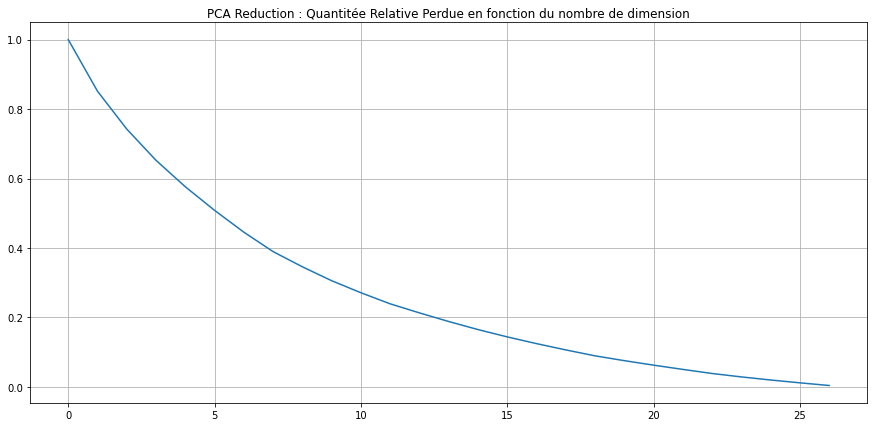

In [56]:
def PCA_Analysis(dataframe):
    min_analyzed_dim = 0
    max_analyzed_dim = len(dataframe.columns)
    
    model_pca = PCA(n_components= max_analyzed_dim)
    predict = model_pca.fit(dataframe).transform(dataframe)
    
    total_coef = {i:1-sum(model_pca.explained_variance_ratio_[:i]) 
                  for i in range(min_analyzed_dim,max_analyzed_dim)}
    print(total_coef)
    plt.figure(figsize=(15, 7)) 
    plt.plot(total_coef.keys(), total_coef.values())
    plt.grid(True)
    plt.title('PCA Reduction : Quantitée Relative Perdue en fonction du nombre de dimension')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Reduction_Proportion.jpg")
    
    plt.show()
if do_Analysis:
    PCA_Analysis(norm_clients_data)

## Obtention des données intéressantes

In [57]:
def get_interest(cluster_center, treshold, columns, K):
    interest = {i:[] for i in range(K)}

    for i in range(len(cluster_center)):
        for key,val in cluster_center[i].items():
            if val > treshold:
                interest[i].append(key)
                
    return interest

def print_interest(conn, interest, cluster, cluster_centers, columns):
    NACK = 0

    conn = engine.connect()
    for key,values in interest.items():
        print("\n\nCluster", key, end=': ')
        proportion = cluster.tolist().count(key)*100/len(cluster)
        print(round(proportion,2),"%",)

        if len(values) == 0:
            NACK += proportion
            continue

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in values:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]
        #print(sql_command)

        df_libele = pd.read_sql(sql_command, conn)

        df_libele["Power"] = [round(cluster_centers[key][i],2) for i in values]

        print(df_libele.sort_values("Power", ascending=False).to_string(index=False))
    conn.close()

    print("\nNACK =", round(NACK,2),"%")

In [58]:
def get_centroid(dataframe, cluster, nbr_cluster):
    cluster_center   = [{c:0 for c in norm_clients_data.columns} for _ in range(nbr_cluster)]
    proportion = [0 for _ in range(nbr_cluster)]
    for i in range(len(cluster)):
        for c in dataframe.columns:
            cluster_center[cluster[i]][c] += dataframe[c][dataframe.index[i]]
        proportion[cluster[i]]  += 1
        
    for i in range(nbr_cluster):
        for c in dataframe.columns:
            cluster_center[i][c] /= proportion[i]
            
    return cluster_center

# KMEANS

5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

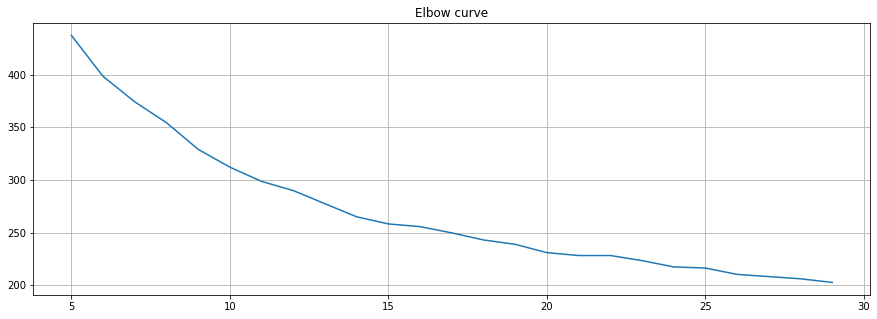

Time Taken to generate Elbow Curve : ~3secondes
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

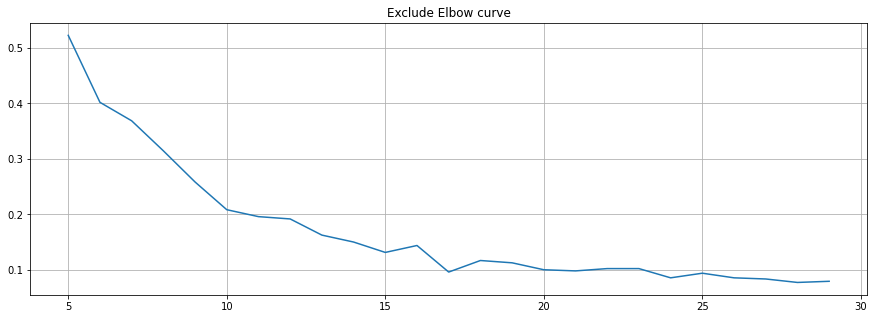

Time Taken to generate Exclude Elbow Curve : ~3secondes


In [59]:
if do_Analysis:
    Analysis(norm_clients_data, treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = Kmin, Kmax = Kmax)

In [60]:
start = time()
model = KMeans(K, n_init = n_init)
model.fit(norm_clients_data)
kmeans_cluster = model.labels_
# environ 1s * n_init * K/10
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~1secondes


In [61]:
kmeans_centers  = model.cluster_centers_
kmeans_centers  = [{norm_clients_data.columns[j]:kmeans_centers[i][j] 
                    for j in range(len(kmeans_centers[i]))} 
                   for i in range(len(kmeans_centers))]
kmeans_interest = get_interest(kmeans_centers, 
                       0.2,
                       norm_clients_data.columns, K)

print_interest(conn, kmeans_interest, kmeans_cluster, kmeans_centers, norm_clients_data.columns)



Cluster 0: 10.42 %
 Univ_KEY        Univ_1     Univ_2            Univ_3  Power
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS   0.99


Cluster 1: 10.83 %
 Univ_KEY   Univ_1 Univ_2 Univ_3  Power
      244 BOISSONS   VINS FRANCE   0.97


Cluster 2: 10.62 %
 Univ_KEY           Univ_1 Univ_2             Univ_3  Power
      174 FRUITS   LEGUMES FRUITS ROUGES ET DES BOIS   0.97
      171 FRUITS   LEGUMES FRUITS           EXOTIQUE   0.23


Cluster 3: 10.83 %
 Univ_KEY           Univ_1 Univ_2             Univ_3  Power
      171 FRUITS   LEGUMES FRUITS           EXOTIQUE   0.98
      174 FRUITS   LEGUMES FRUITS ROUGES ET DES BOIS   0.22


Cluster 4: 4.58 %
 Univ_KEY           Univ_1       Univ_2        Univ_3  Power
      171 FRUITS   LEGUMES       FRUITS      EXOTIQUE   0.97
      299   PETIT DEJEUNER VIENNOISERIE VIENNOISERIES   0.21


Cluster 5: 5.83 %
 Univ_KEY        Univ_1      Univ_2            Univ_3  Power
      392 PRET A MANGER  SANDWICHES SANDWICHES FROIDS   0.88
      966  

In [62]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~1617secondes


# VISUALISATION PCA

In [64]:
def PCA_Visualisation(data, target=[], centroid=[], method = "", threeD = False):
    start = time()

    model_pca = PCA(n_components= 2)
    predict = model_pca.fit(data).transform(data)
    
    
    print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))
    
    plt.figure(figsize=(15, 7))  
    if list(target):
        plt.scatter(predict[:,0],predict[:,1], c=target, alpha=.8)
    else: 
        plt.scatter(predict[:,0],predict[:,1])
    if list(centroid):
        clust_predict = model_pca.transform(centroid)
        plt.scatter(clust_predict[:,0],clust_predict[:,1], color='r')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of dataset - ' + method + ' - Cluster = ' + str(K))

    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster-"+str(K)+"-"+method+".jpg")
    
    if threeD:
        model_pca = PCA(n_components= 3)
        predict = model_pca.fit(data).transform(data)
        print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))


        plt.figure(figsize=(30, 30)) 
        ax = plt.axes(projection='3d')

        ax.scatter3D(predict[:,0], predict[:,1], predict[:,2], c=target);

        plt.title('PCA of dataset in 3D - ' + method)

        if save_fig:
            plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster_3D-"+str(K)+"-"+method+".jpg")
    
    # environ 1.5s
    print("Time Taken to show PCA : ~" + str(int(time() - start)) + "secondes")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.14874187 0.10892828]
Time Taken to show PCA : ~0secondes


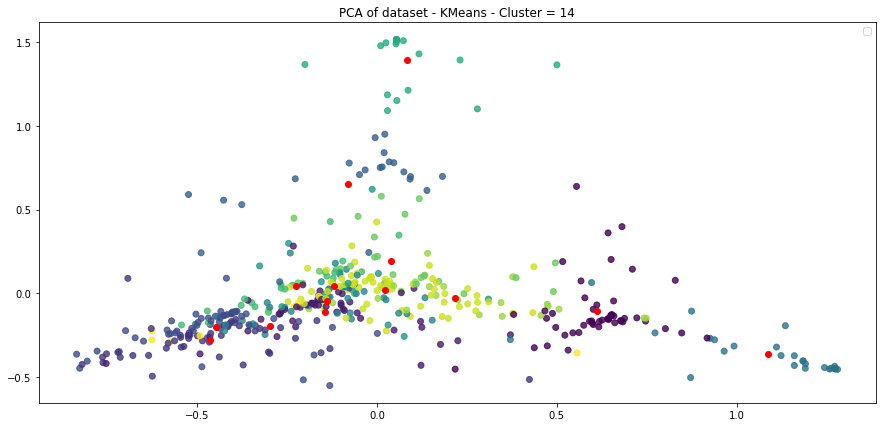

In [65]:
PCA_Visualisation(norm_clients_data,
                  kmeans_cluster, 
                  [list(dic.values()) for dic in kmeans_centers],
                  method = 'KMeans',
                  threeD = threeD)

# HIERARCHICAL CLUSTERING

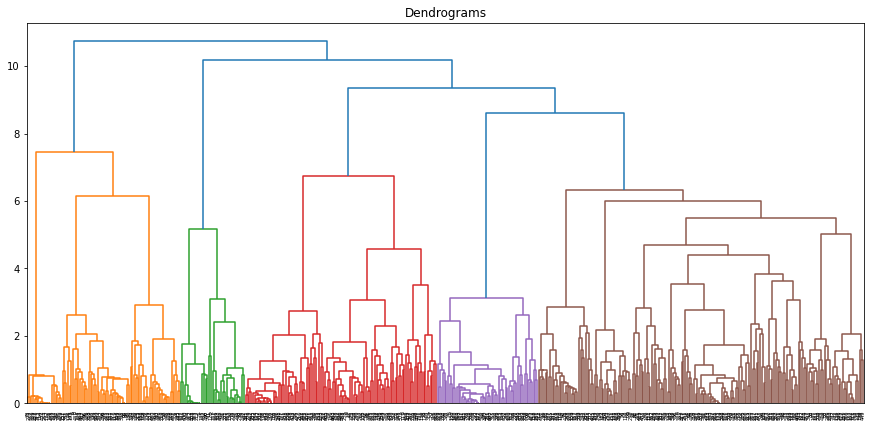

Time Taken to fit model : ~7secondes
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

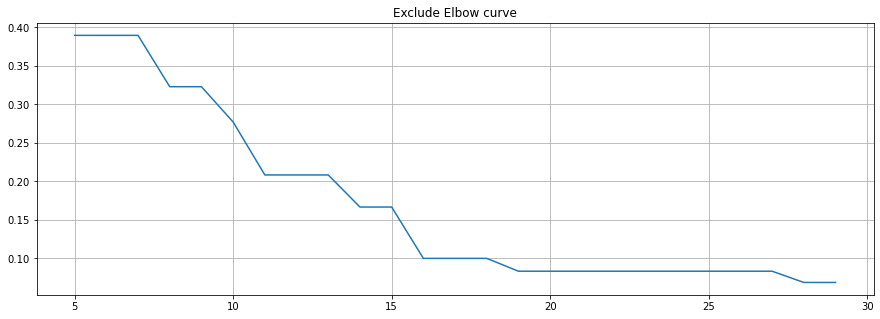

Time Taken to generate Exclude Elbow Curve : ~2secondes


In [66]:
if do_Analysis:
    Analysis(norm_clients_data.head(max_fitted),
             treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = Kmin, Kmax = Kmax, 
             method = 'ward', Algo= 'hierarchical')

In [67]:
start  = time()

method = method            # types de méthode: ward complete average single

hierarchical_model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage=method)  
hierarchical_model.fit(norm_clients_data.head(max_fitted))
print(hierarchical_model)
# 15s * (N/10k)²
print("Time Taken to fit/predict model : ~" + str(int(time() - start)) + "secondes")

AgglomerativeClustering(n_clusters=14)
Time Taken to fit/predict model : ~0secondes


In [68]:
start = time()

hierarchical_cluster  = hierarchical_model.labels_
hierarchical_centroid = get_centroid(norm_clients_data, hierarchical_cluster, K)

hierarchical_interest = get_interest(hierarchical_centroid, 
                       Standard_Tresh if Standard_Norm else MinMax_Tesh,
                       norm_clients_data.columns, K)

print_interest(conn, hierarchical_interest, hierarchical_cluster, list(hierarchical_centroid), norm_clients_data.columns)

# environ 30s
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes")



Cluster 0: 13.54 %
 Univ_KEY           Univ_1 Univ_2             Univ_3  Power
      174 FRUITS   LEGUMES FRUITS ROUGES ET DES BOIS   0.79
      171 FRUITS   LEGUMES FRUITS           EXOTIQUE   0.34


Cluster 1: 16.67 %


Cluster 2: 4.38 %
 Univ_KEY         Univ_1       Univ_2        Univ_3  Power
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES   0.98


Cluster 3: 6.04 %
 Univ_KEY        Univ_1         Univ_2            Univ_3  Power
      392 PRET A MANGER     SANDWICHES SANDWICHES FROIDS   0.92
      431 PRET A MANGER POTAGE SERVICE           MARMITE   0.45


Cluster 4: 12.08 %
 Univ_KEY   Univ_1 Univ_2 Univ_3  Power
      244 BOISSONS   VINS FRANCE   0.93


Cluster 5: 3.12 %
 Univ_KEY  Univ_1     Univ_2                Univ_3  Power
      148 DESSERT PATISSERIE PATISSERIE INDIVIVUEL   0.96


Cluster 6: 4.17 %
 Univ_KEY        Univ_1  Univ_2  Univ_3  Power
      960 PRET A MANGER SALADES POISSON   0.73
      959 PRET A MANGER SALADES  VIANDE   0.31


Cluster 7: 6.67 %
 Univ_KEY 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.14874187 0.10892828]
Time Taken to show PCA : ~0secondes


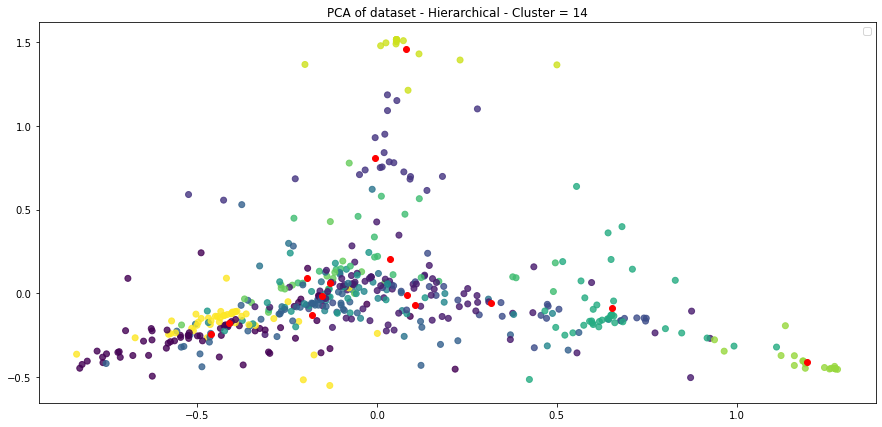

In [69]:
PCA_Visualisation(norm_clients_data.head(max_fitted), 
                  hierarchical_cluster,
                  [list(dic.values()) for dic in hierarchical_centroid],
                  method = 'Hierarchical',
                  threeD = threeD)

In [70]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~1709secondes


## PCA Dimension reductor + KMeans

In [71]:
model_pca = PCA(n_components= nbr_dim_keep)
predict = model_pca.fit(norm_clients_data).transform(norm_clients_data)

In [72]:
new_datas = pd.DataFrame(index=norm_clients_data.index, data = predict)
print(new_datas)

                 0         1         2         3         4         5  \
805110   -0.408176 -0.177866 -0.232928  0.161643  0.636075  0.203671   
10104973  0.054313  1.515110 -0.231010 -0.187075  0.198282 -0.296964   
9324381  -0.227241  0.683821 -0.392690 -0.364949 -0.281703 -0.208113   
602422   -0.372082 -0.427773 -0.639630 -0.155575  0.343000  0.076358   
9684641   0.181294 -0.138516  0.236608  0.007043  0.065154 -0.300044   
...            ...       ...       ...       ...       ...       ...   
9285142  -0.017032  0.094498  0.108906  0.051580 -0.103929  0.176432   
9270121   0.010460  0.045661  0.131442  0.157409 -0.087071  0.127681   
285942   -0.162699 -0.070823  0.769538 -0.474486  0.051759  0.010179   
9478146  -0.102985  0.041695  0.067280  0.105228 -0.181382  0.129740   
1087764   0.380241 -0.126216  0.109760  0.378980 -0.311579 -0.015859   

                 6         7         8         9  
805110   -0.063934 -0.185158 -0.088047 -0.097536  
10104973 -0.172396 -0.204265 -0.1

5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

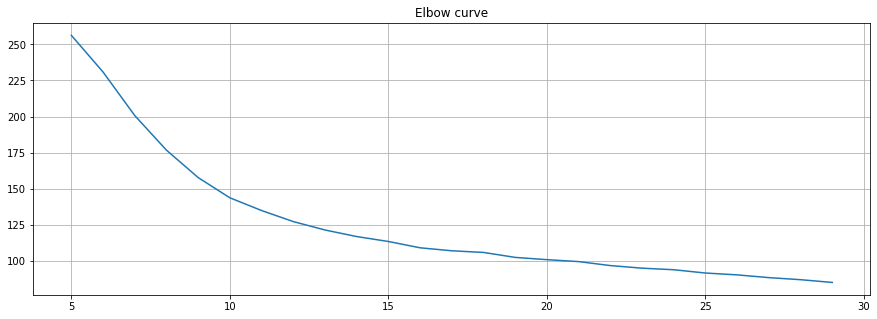

Time Taken to generate Elbow Curve : ~3secondes
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

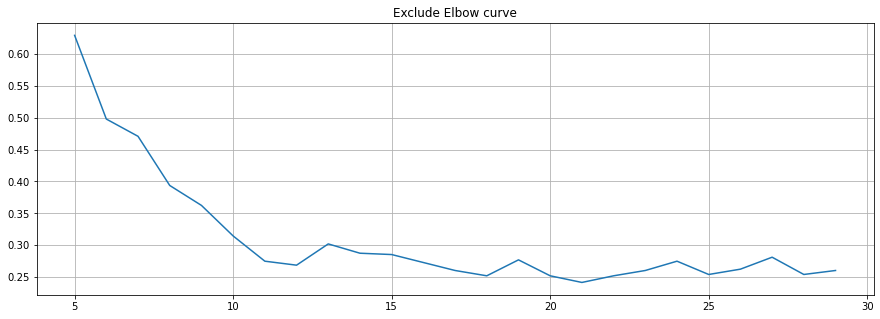

Time Taken to generate Exclude Elbow Curve : ~3secondes


In [73]:
if do_Analysis:
    Analysis(new_datas, treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = Kmin, Kmax = Kmax)

In [74]:
start = time()

model = KMeans(K_PCA, n_init = n_init)
model.fit(new_datas)

# environ 10s
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~1secondes


In [75]:
start = time()

PCA_cluster  = model.labels_
PCA_centroid = get_centroid(norm_clients_data, PCA_cluster, K_PCA)        
        
PCA_interest = get_interest(PCA_centroid, 
                       Standard_Tresh if Standard_Norm else MinMax_Tesh,
                       norm_clients_data.columns, K)

print_interest(conn, PCA_interest, PCA_cluster, PCA_centroid, norm_clients_data.columns)

#environ 2min
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes")



Cluster 0: 11.25 %
 Univ_KEY   Univ_1 Univ_2 Univ_3  Power
      244 BOISSONS   VINS FRANCE   0.97


Cluster 1: 10.42 %
 Univ_KEY           Univ_1 Univ_2   Univ_3  Power
      171 FRUITS   LEGUMES FRUITS EXOTIQUE   0.97


Cluster 2: 5.0 %
 Univ_KEY        Univ_1         Univ_2  Univ_3  Power
      431 PRET A MANGER POTAGE SERVICE MARMITE   0.95


Cluster 3: 4.38 %
 Univ_KEY         Univ_1       Univ_2        Univ_3  Power
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES   0.89


Cluster 4: 7.71 %
 Univ_KEY        Univ_1         Univ_2         Univ_3  Power
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD   0.89


Cluster 5: 7.5 %
 Univ_KEY           Univ_1 Univ_2             Univ_3  Power
      174 FRUITS   LEGUMES FRUITS ROUGES ET DES BOIS   0.98


Cluster 6: 6.04 %
 Univ_KEY        Univ_1      Univ_2            Univ_3  Power
      392 PRET A MANGER  SANDWICHES SANDWICHES FROIDS   0.88
      966       DESSERT  PATISSERIE           IMPULSE   0.87
      228      BOISSONS SOFT 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.14874187 0.10892828]
Time Taken to show PCA : ~0secondes


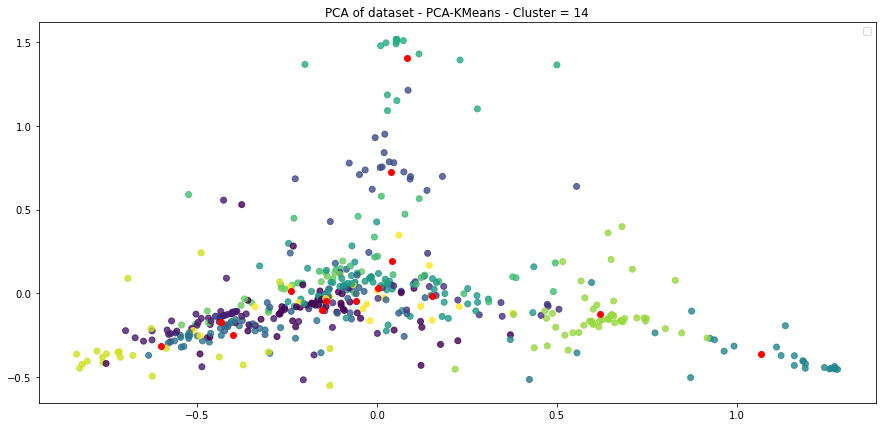

In [76]:
PCA_Visualisation(norm_clients_data, 
                  PCA_cluster, 
                  [list(dic.values()) for dic in PCA_centroid],
                  method = 'PCA-KMeans',
                  threeD = threeD)

In [77]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~1717secondes


## Reconstruction des résultats du KMeans A LA MAIN

In [ ]:
cluster_correspondance = {0:0, 1:1, 2:2, 3:3, 4:0, 5:1, 6:4,7:5, 8:6, 9:7, 10:0, 11:3, 12:0, 13:8}
new_cluster = []
for c in cluster:
    new_cluster.append(cluster_correspondance[c])
new_cluster_center = [[0 for _ in range(len(cluster_centers[0]))] for _ in range(9)]
cluster_proportion = [0 for _ in range(9)]
for i in range(len(cluster_centers)):
    cluster_proportion[cluster_correspondance[i]] += cluster.tolist().count(i)
    for j in range(len(cluster_centers[i])):
        new_cluster_center[cluster_correspondance[i]][j] += cluster_centers[i][j]*cluster.tolist().count(i)

for i in range(len(new_cluster_center)):
    for j in range(len(new_cluster_center[i])):
        new_cluster_center[i][j] /= cluster_proportion[i]

In [ ]:
PCA_Visualisation(norm_clients_data, 
                  new_cluster, 
                  new_cluster_center, 
                  method = 'KMeans rebuild to 9', 
                  threeD = threeD)

In [ ]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

In [ ]:
# conn = engine.connect()

# for i in range(len(cluster)):
#     sql_cmd = '''UPDATE  ['''+DB+'''].[DWH].[Dim_'''+TABLE_CONSO+''']
#     SET ['''+TABLE_CONSO+'''.Segment_Clientele] = ''' + str(cluster_correspondance[cluster[i]]) +''' 
#     WHERE ['''+TABLE_CONSO+'''.KEY] = ''' + str(norm_clients_data.index[i])
    
#     conn.execute(sql_cmd)
    
#     if not i % 1000:
#         print(i*100/len(cluster), "%")
# conn.close()

In [ ]:
print(norm_clients_data)
PCA_Visualisation(norm_clients_data, method = 'Standard Normalization')